In [33]:
from MetricLearning.src.metric_learning_adjacent.build_graphs import *
from tqdm import tqdm

In [2]:
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

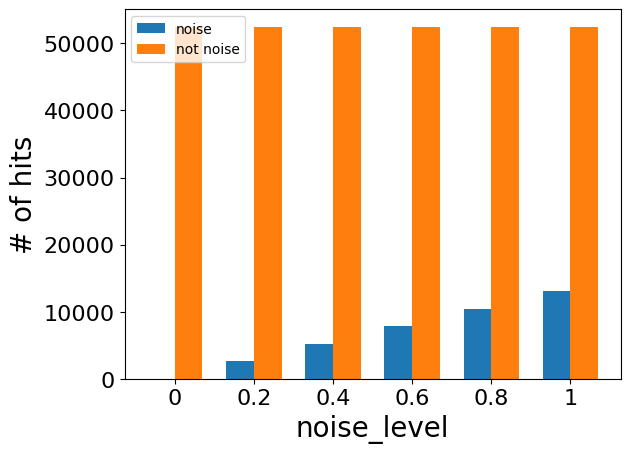

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['default', '/global/homes/a/aoka/style.mplstyle'])

noise_hits = []
not_noise_hits = []
noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    n_noise = sum(truth['particle_id']==0)
    noise_hits.append(n_noise)
    not_noise_hits.append(len(truth)-n_noise)

x = np.arange(len(noise_keeps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noise_hits, width, label='noise')
rects2 = ax.bar(x + width/2, not_noise_hits, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('noise_level')
ax.set_xticks(x)
ax.set_xticklabels(noise_keeps)
ax.legend()

# Embedding

In [4]:
def get_one_emb_eff_purity(index, hits, truth, emb_neighbors, only_adjacent=False):
    vol = hits[['volume_id', 'layer_id']].values.T
    hit = hits.iloc[index]
    pid = truth.iloc[index]['particle_id']
    
    # get true neighbors based on particle id
    if pid == 0:
        true_neighbors = []
    else:
        hit_idx = truth[truth['particle_id']==pid]['hit_id']
        true_hits = hits[hits['hit_id'].isin(hit_idx) & (hits['hit_id'] != hit['hit_id'])]
        true_neighbors = true_hits.index.values.astype(int)
        if only_adjacent:
            true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], true_neighbors, vol[0], vol[1])
    
    emb_neighbors = emb_neighbors[index]
    if only_adjacent:
        emb_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], emb_neighbors, vol[0], vol[1])
    
    # calculate purity and eff
    n_true_neighbors = sum(map(lambda n : n in true_neighbors, emb_neighbors))
    purity = n_true_neighbors / len(emb_neighbors) if len(emb_neighbors) > 0 else None
    efficiency = n_true_neighbors / len(true_neighbors) if len(true_neighbors) > 0 else None
    return purity, efficiency

In [5]:
def get_emb_eff_purity(hits, truth, emb_neighbors, only_adjacent=False):
    n_iter = len(hits)
    purity = []
    efficiency = []

    for i in tqdm(range(n_iter)):
        p, eff = get_one_emb_eff_purity(i, hits, truth, emb_neighbors, only_adjacent)
        if p: purity.append(p)
        if eff: efficiency.append(eff)

    return purity, efficiency

# Filtering

In [18]:
def use_filter(hits, neighbors, threshold = 0.95):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    filter_pairs, _ = apply_filter(idx_pairs, scores, threshold)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    return idx_pairs, filter_pairs

In [19]:
def get_filter_eff_purity(hits, truth, idx_pairs, fiter_pairs):
    # get true pairs
    true_pairs = []
    truth_np = np.array(truth.values)
    
    with torch.autograd.no_grad():
        for i, pair in tqdm(enumerate(idx_pairs)):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a != 0 and hit_a == hit_b: #compare particle id
                true_pairs.append((pair[0], pair[1]))
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

# Overall purity and efficiency

In [8]:
def get_overall_eff_purity(hits, truth, idx_pairs, filter_pairs):
    vol = hits[['volume_id', 'layer_id']].values.T
    # get true pairs from original dataset
    true_pairs = []
    for pid in tqdm(truth['particle_id'].unique()):
        if pid == 0: continue
        seed_hits = hits[truth['particle_id']==pid].index.values.astype(int)
        for i in seed_hits:
            hit = hits.iloc[i]
            true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], seed_hits, vol[0], vol[1])
            true_pairs += [(i, n) for n in true_neighbors]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

# Plotting

In [9]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_with_3xnoise"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [03:45<00:00, 232.75it/s]


emb result: 0.02240102949636367 0.9844205727792658
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


4802846it [00:07, 628665.81it/s]
  0%|          | 39/8187 [00:00<00:20, 388.74it/s]

filter result: 0.15312294543063773 0.9090650153492347


100%|██████████| 8187/8187 [00:21<00:00, 388.43it/s]


overall result: 0.15312294543063773 0.8521855221518987
event: 0.2 number of hits: 55094


100%|██████████| 55094/55094 [03:44<00:00, 245.76it/s]


emb result: 0.021407016702153017 0.9844205727792658
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


5230173it [00:09, 549245.25it/s]
  0%|          | 40/8188 [00:00<00:20, 398.60it/s]

filter result: 0.14476701503394354 0.9090554254488681


100%|██████████| 8188/8188 [00:25<00:00, 327.16it/s]


overall result: 0.14476701503394354 0.8521855221518987
event: 0.4 number of hits: 57699


100%|██████████| 57699/57699 [03:45<00:00, 255.72it/s]


emb result: 0.020569034138142935 0.9844205727792658
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


5716128it [00:08, 657733.88it/s]
  1%|          | 50/8188 [00:00<00:16, 499.21it/s]

filter result: 0.1365882807942989 0.9090937862643739


100%|██████████| 8188/8188 [00:20<00:00, 407.90it/s]


overall result: 0.1365882807942989 0.8521855221518987
event: 0.6 number of hits: 60314


100%|██████████| 60314/60314 [03:58<00:00, 252.55it/s]


emb result: 0.0198649995278551 0.9844205727792658
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


6231163it [00:10, 619015.45it/s]
  1%|          | 50/8188 [00:00<00:16, 497.01it/s]

filter result: 0.12874054685562497 0.9090841957569812


100%|██████████| 8188/8188 [00:21<00:00, 385.18it/s]


overall result: 0.12874054685562497 0.8521855221518987
event: 0.8 number of hits: 62859


100%|██████████| 62859/62859 [03:53<00:00, 269.72it/s]


emb result: 0.019247257259679726 0.9844205727792658
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


6774600it [00:11, 581550.77it/s]
  1%|          | 44/8188 [00:00<00:18, 436.66it/s]

filter result: 0.12138786135472983 0.9090650153492347


100%|██████████| 8188/8188 [00:22<00:00, 357.39it/s]


overall result: 0.12138786135472983 0.8521855221518987
event: 1 number of hits: 65518


100%|██████████| 65518/65518 [03:47<00:00, 287.63it/s]


emb result: 0.018679352574782 0.9844205727792658
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7377480it [00:11, 639327.32it/s]
  1%|          | 53/8188 [00:00<00:15, 525.46it/s]

filter result: 0.11380871503775883 0.9090650153492347


100%|██████████| 8188/8188 [00:20<00:00, 390.92it/s]


overall result: 0.11380871503775883 0.8521855221518987


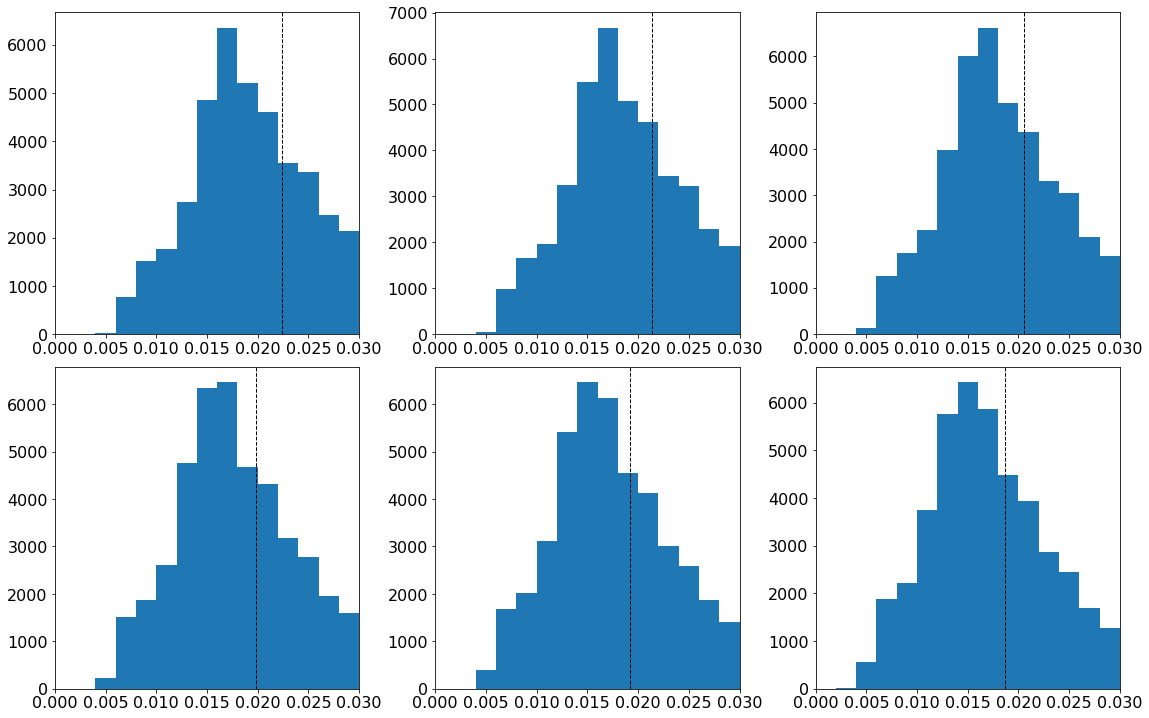

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
emb_ps = []
emb_efs = []
filter_ps = []
filter_efs = []
overall_ps = []
overall_efs = []

fig, axes = plt.subplots(2, 3, figsize=(16,10))

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors, only_adjacent=True)
    axes[i//3][i%3].hist(emb_purity, 50, range=(0, 0.1))
    emb_purity = sum(emb_purity)/len(emb_purity)
    emb_efficiency = sum(emb_efficiency)/len(emb_efficiency)
    print("emb result:", emb_purity, emb_efficiency)
    axes[i//3][i%3].axvline(emb_purity, color='k', linestyle='dashed', linewidth=1)
    axes[i//3][i%3].set_xlim(0, 0.03)
    emb_ps.append(emb_purity)
    emb_efs.append(emb_efficiency)
    
    #apply filter
    idx_pairs, filter_pairs = use_filter(hits, neighbors)
    
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, idx_pairs, filter_pairs)
    print("filter result:", filter_purity, filter_efficiency)
    filter_ps.append(filter_purity)
    filter_efs.append(filter_efficiency)
    
    overall_purity, overall_efficiency = get_overall_eff_purity(hits, truth, idx_pairs, filter_pairs)
    print("overall result:", overall_purity, overall_efficiency)
    overall_ps.append(overall_purity)
    overall_efs.append(overall_efficiency)
    
plt.tight_layout()

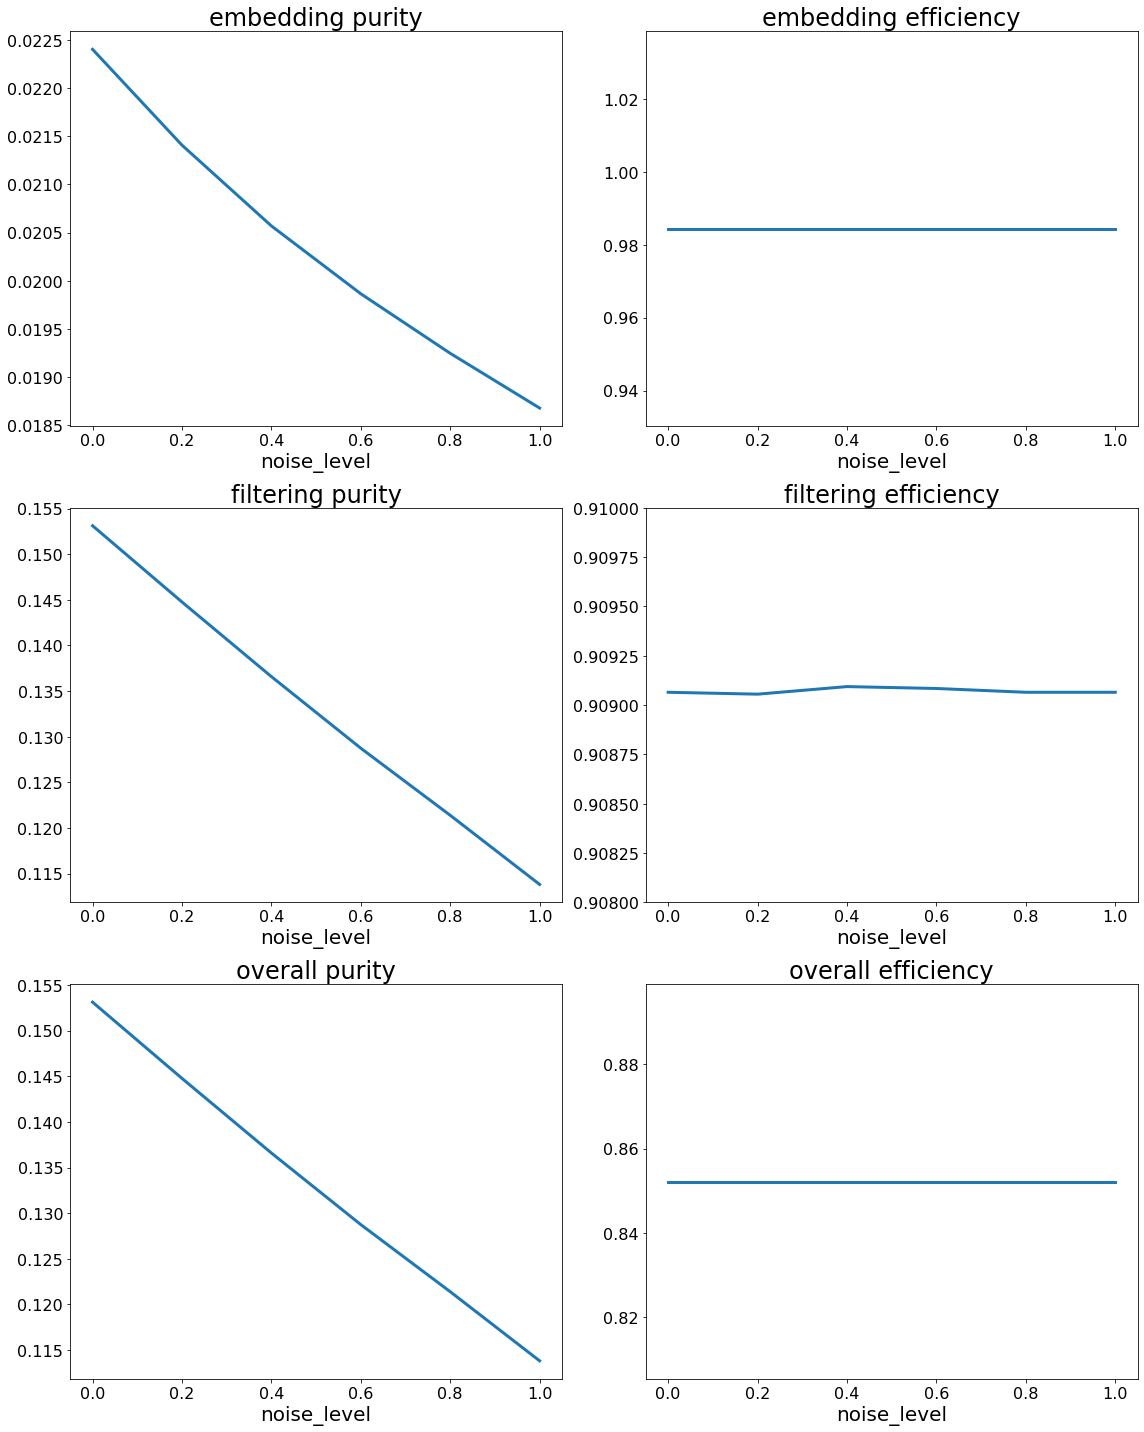

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,20))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, emb_ps)
ax1.set_title("embedding purity")
ax1.set_xlabel("noise_level")
ax2.plot(x, emb_efs)
ax2.set_title("embedding efficiency")
ax2.set_xlabel("noise_level")

ax3.plot(x, filter_ps)
ax3.set_title("filtering purity")
ax3.set_xlabel("noise_level")
ax4.plot(x, filter_efs)
ax4.set_ylim(0.908, 0.91)
ax4.set_title("filtering efficiency")
ax4.set_xlabel("noise_level")

ax5.plot(x, overall_ps)
ax5.set_title("overall purity")
ax5.set_xlabel("noise_level")
ax6.plot(x, overall_efs)
ax6.set_title("overall efficiency")
ax6.set_xlabel("noise_level")

plt.tight_layout()

# get filtering efficiency of 0.9622583833464098

In [13]:
def get_filter_eff_purity_with_threshold(hits, truth, idx_pairs, scores, true_pairs, threshold):
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, threshold)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

In [14]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_with_3xnoise"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

In [15]:
event_name = "event000001000.pickle"
data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_0/preprocess_raw"
hits, truth = load_event(data_path, event_name)
    
neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)

vol = hits[['volume_id', 'layer_id']].values.T

batch_size = 64
num_workers = 12 if DEVICE=='cuda' else 0
dataset = EdgeData(hits[feature_names].values, vol, neighbors)
loader = DataLoader(dataset,
                    batch_size = batch_size,
                    num_workers = num_workers,
                    collate_fn = my_collate)
# apply filter model
idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)

# get true pairs
true_pairs = []
truth_np = np.array(truth.values)

with torch.autograd.no_grad():
    for i, pair in tqdm(enumerate(idx_pairs)):
        hit_a = truth_np[pair[0], 1]
        hit_b = truth_np[pair[1], 1]
        if hit_a != 0 and hit_a == hit_b: #compare particle id
            true_pairs.append((pair[0], pair[1]))

    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered


54054it [00:00, 540532.78it/s]

  100% of doublets filtered


4802846it [00:08, 576227.67it/s]


In [16]:
lower = 0.0
higher = 1.0
for i in tqdm(range(100)):
    mid = (lower + higher) / 2
    purity, efficiency = get_filter_eff_purity_with_threshold(hits, truth, idx_pairs, scores, true_pairs, mid)
    if efficiency > 0.9622583833464098:
        lower = mid
    else:
        higher = mid
mid

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


0.8766906559467316

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
filter_ps = []
filter_efs = []

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    idx_pairs, filter_pairs = use_filter(hits, neighbors, threshold=0.8766906559467316)
    
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, idx_pairs, filter_pairs)
    print("filter result:", filter_purity, filter_efficiency)
    filter_ps.append(filter_purity)
    filter_efs.append(filter_efficiency)
    
plt.tight_layout()

event: 0 number of hits: 52482
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


4802846it [00:06, 695694.05it/s]


filter result: 0.11950184854749496 0.9622651461605815
event: 0.2 number of hits: 55094
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


5230173it [00:07, 671713.29it/s]


filter result: 0.11227690111026316 0.9622549950418803
event: 0.4 number of hits: 57699
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


5716128it [00:08, 660527.41it/s]


filter result: 0.10526680222775647 0.9622956008017723
event: 0.6 number of hits: 60314
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


6231163it [00:08, 706470.53it/s]


filter result: 0.0985835424623838 0.9622854490405207
event: 0.8 number of hits: 62859
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


6774600it [00:09, 686643.88it/s]


filter result: 0.09238326252196503 0.9622651461605815
event: 1 number of hits: 65518
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7377480it [00:10, 695273.39it/s]


filter result: 0.08614279252011299 0.9622651461605815


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'noise_level')

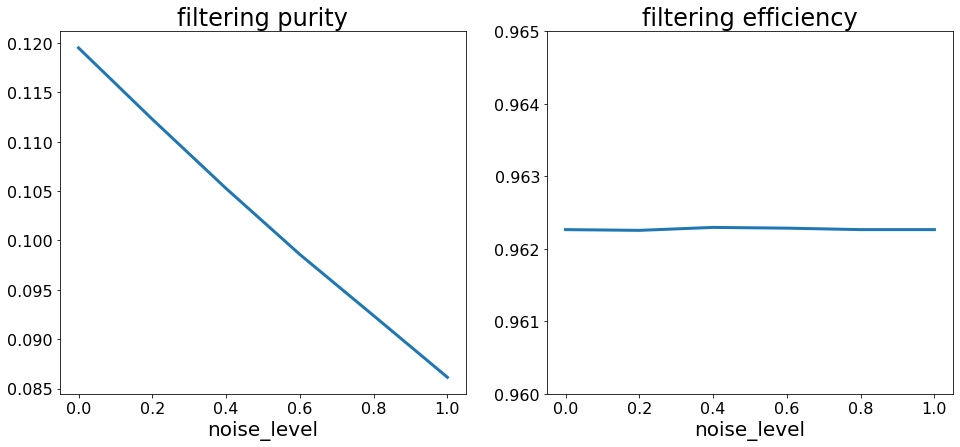

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,20/3))
x = [float(keep) for keep in noise_keeps]

ax1.plot(x, filter_ps)
ax1.set_title("filtering purity")
ax1.set_xlabel("noise_level")
ax2.plot(x, filter_efs)
ax2.set_ylim(0.96, 0.965)
ax2.set_title("filtering efficiency")
ax2.set_xlabel("noise_level")

# Get embedding efficiency of 99.2%

In [28]:
event_name = "event000001000.pickle"
data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_0.4/preprocess_raw"
hits, truth = load_event(data_path, event_name)

In [ ]:
lower = 0.46875
higher = 1.0
for i in range(100):
    mid = (lower + higher) / 2
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, mid)
    purity, efficiency = get_emb_eff_purity(hits, truth, neighbors, True)
    print(mid, sum(efficiency)/len(efficiency))
    if sum(efficiency)/len(efficiency) < 0.992:
        lower = mid
    else:
        higher = mid

100%|██████████| 57699/57699 [04:30<00:00, 213.02it/s]


0.734375 0.9951145588909566


100%|██████████| 57699/57699 [04:01<00:00, 239.09it/s]


0.6015625 0.9927662746058965


100%|██████████| 57699/57699 [03:48<00:00, 252.94it/s]


0.53515625 0.9907156328224115


100%|██████████| 57699/57699 [03:53<00:00, 246.64it/s]


0.568359375 0.9916864754098356


100%|██████████| 57699/57699 [04:00<00:00, 240.37it/s]


0.5849609375 0.9921876065403861


100%|██████████| 57699/57699 [03:54<00:00, 246.34it/s]


0.57666015625 0.9918882679276949


100%|██████████| 57699/57699 [03:57<00:00, 243.25it/s]


0.580810546875 0.9920856610800739


100%|██████████| 57699/57699 [04:00<00:00, 239.99it/s]


0.5787353515625 0.9919890162368669


100%|██████████| 57699/57699 [03:55<00:00, 245.15it/s]


0.57977294921875 0.9920084315651602


 30%|██▉       | 17107/57699 [01:07<02:50, 238.34it/s]

In [34]:
mid

0.5795761051563175

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
emb_ps = []
emb_efs = []

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.5795761051563175)
    
    emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors, only_adjacent=True)
    emb_purity = sum(emb_purity)/len(emb_purity)
    emb_efficiency = sum(emb_efficiency)/len(emb_efficiency)
    print("emb result:", emb_purity, emb_efficiency)
    emb_ps.append(emb_purity)
    emb_efs.append(emb_efficiency)

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [03:46<00:00, 231.48it/s]


emb result: 0.010144098201422704 0.9920014462203846
event: 0.2 number of hits: 55094


100%|██████████| 55094/55094 [03:53<00:00, 236.01it/s]


emb result: 0.009695761212251724 0.9920014462203846
event: 0.4 number of hits: 57699


100%|██████████| 57699/57699 [03:56<00:00, 244.35it/s]


emb result: 0.009318333097305816 0.9920014462203846
event: 0.6 number of hits: 60314


100%|██████████| 60314/60314 [03:59<00:00, 252.27it/s]


emb result: 0.008990113629584023 0.9920014462203846
event: 0.8 number of hits: 62859


100%|██████████| 62859/62859 [04:01<00:00, 260.15it/s]


emb result: 0.008709167824005505 0.9920014462203846
event: 1 number of hits: 65518


100%|██████████| 65518/65518 [04:08<00:00, 263.87it/s]

emb result: 0.008450840619686525 0.9920014462203846


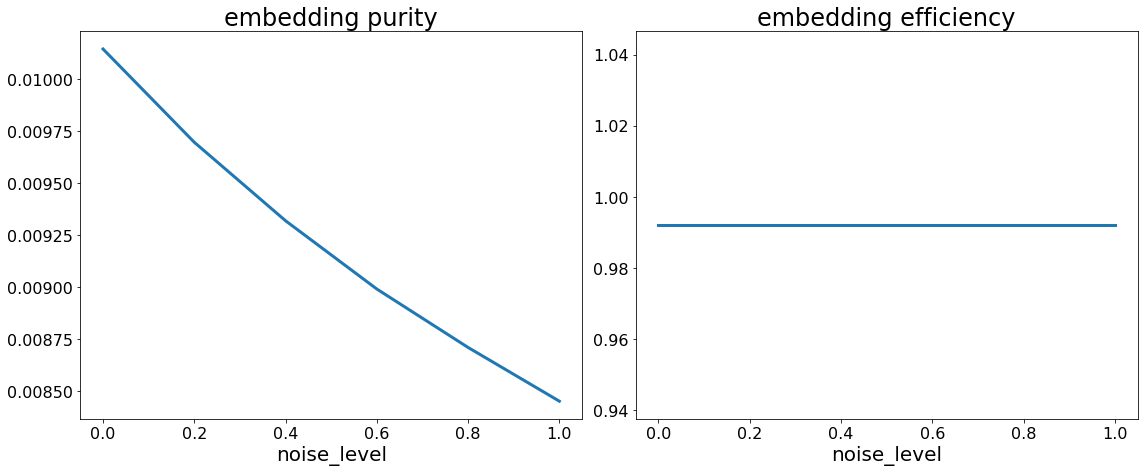

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,20/3))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, emb_ps)
ax1.set_title("embedding purity")
ax1.set_xlabel("noise_level")
ax2.plot(x, emb_efs)
ax2.set_title("embedding efficiency")
ax2.set_xlabel("noise_level")

plt.tight_layout()